In [1]:
import duckdb
import pathlib
SF = 0.1  # Scale Factor
if SF <1 :
 schema = f"{str(SF).replace('.', '_')}"
else :
 schema = f'DS{SF:02d}'
import os
folder_path = '/some_location'
os.makedirs(folder_path, exist_ok=True)
db_path = folder_path +"/"+ schema +".duckdb"
if not pathlib.Path(db_path).exists():
    con = duckdb.connect(db_path)
    con.sql("SET memory_limit = '14GB' ")
    con.sql(f"CALL dsdgen(sf={SF})")
    con.close()

using lm studio to create a local server : https://lmstudio.ai/

semantic model as system prompt : https://github.com/djouallah/Fabric_Notebooks_Demo/blob/main/SemanticModel/sm/semantic_model.txt

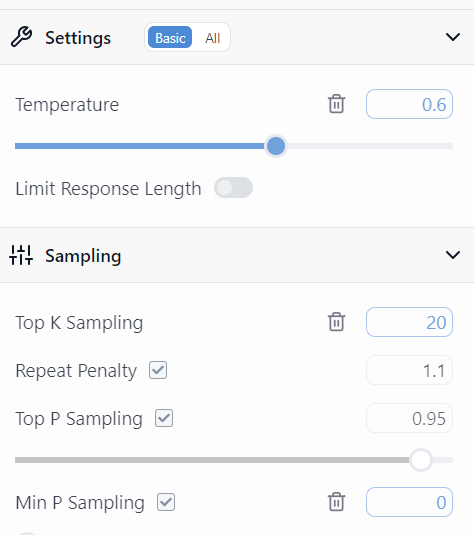

Laptop used:
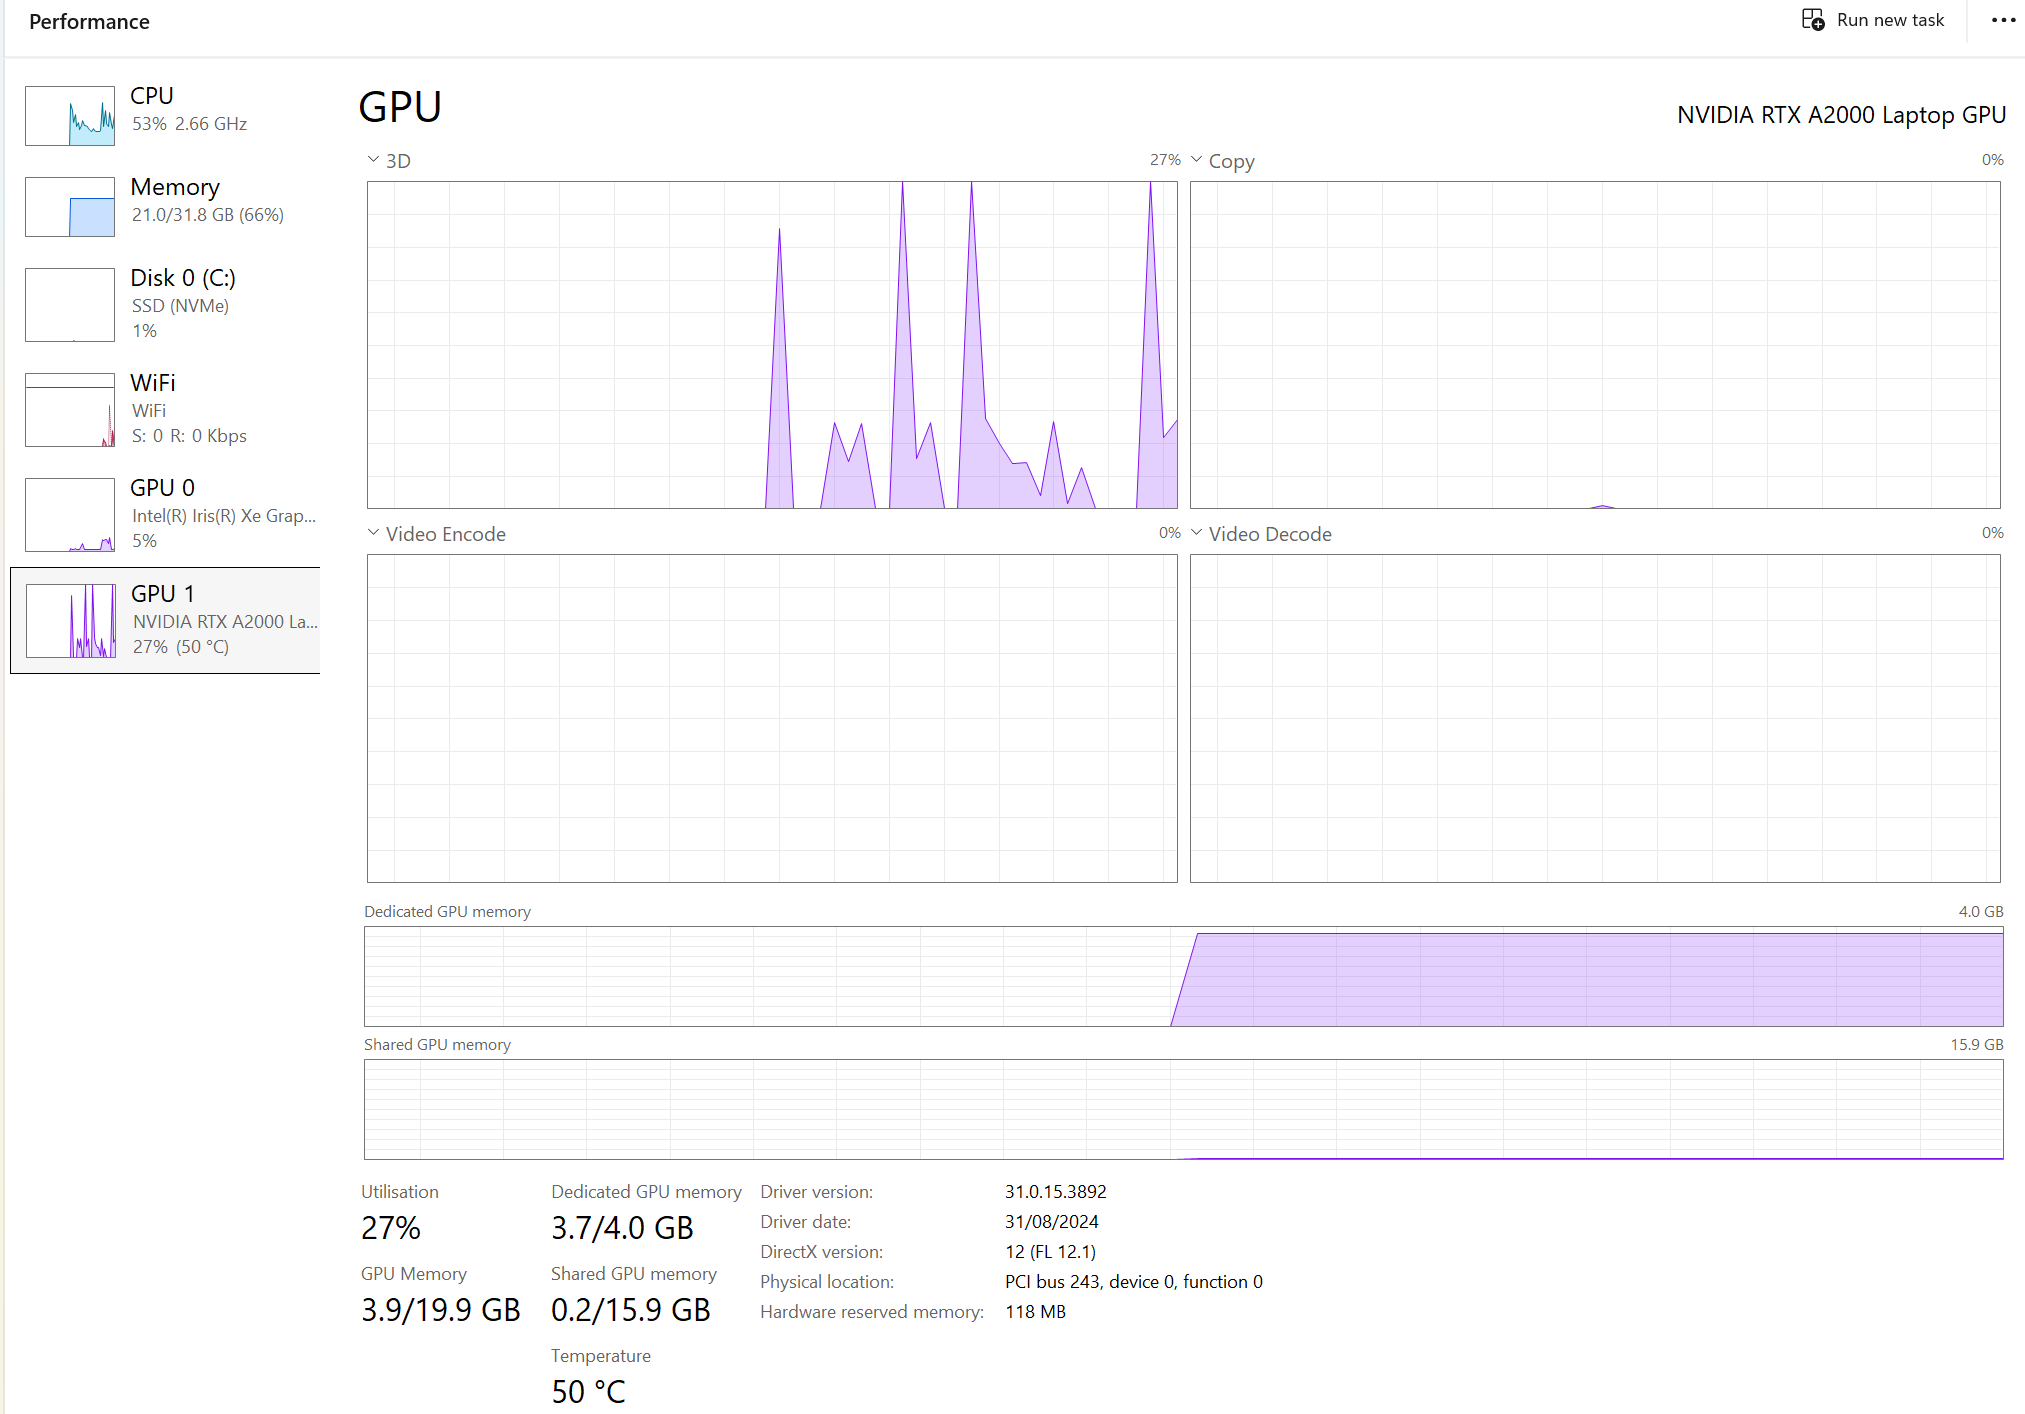

In [2]:
import lmstudio as lms
model = lms.llm("qwen3-14b")
import duckdb
con = duckdb.connect()
con.sql(f""" attach or replace '{db_path}' as ds(read_only) ; use ds """)
def textto_sql(text):
    result = model.respond(text).content.replace("<think>", "").replace("</think>", "")
    return result

In [3]:
%%time
result = textto_sql("return rate per year")
print(result)





-- return rate per year  
WITH SalesYear AS (
    -- Calculate total sales per year
    SELECT
        d.d_year AS sale_year,
        SUM(ss.ss_sales_price * ss.ss_quantity) AS total_sales_amt -- Corresponds to total_sales measure
    FROM store_sales AS ss
    JOIN date_dim AS d ON ss.ss_sold_date_sk = d.d_date_sk
    GROUP BY d.d_year
), ReturnsYear AS (
    -- Calculate total returns per year
    SELECT
        d.d_year AS return_year,
        SUM(sr.sr_return_amt) AS total_returns_amt -- Corresponds to total_returns measure
    FROM store_returns AS sr
    JOIN date_dim AS d ON sr.sr_returned_date_sk = d.d_date_sk
    GROUP BY d.d_year
)
-- Final calculation joining sales and returns by year and computing return rate
SELECT
    COALESCE(sy.sale_year, ry.return_year) AS year,
    COALESCE(sy.total_sales_amt, 0) AS total_sales,
    COALESCE(ry.total_returns_amt, 0) AS total_returns,
    (COALESCE(ry.total_returns_amt, 0) / NULLIF(COALESCE(sy.total_sales_amt, 0), 0)) * 100 AS retu

In [4]:
con.sql(result).show()

┌───────┬───────────────┬───────────────┬────────────────────┐
│ year  │  total_sales  │ total_returns │    return_rate     │
│ int32 │ decimal(38,2) │ decimal(38,2) │       double       │
├───────┼───────────────┼───────────────┼────────────────────┤
│  1998 │  102297175.54 │    3174362.68 │ 3.1030794968124686 │
│  1999 │   99370448.87 │    5123614.42 │  5.156074545565248 │
│  2000 │  103184045.02 │    5280670.28 │  5.117719778262673 │
│  2001 │  102172898.92 │    5228059.14 │ 5.1168746265029625 │
│  2002 │  100289052.41 │    5118797.44 │  5.104044077586275 │
│  2003 │     873774.86 │    2222881.70 │ 254.39982331375387 │
└───────┴───────────────┴───────────────┴────────────────────┘



In [5]:
%%time
result = textto_sql(" What is the return rate by customer age group? ")
print(result)





-- give me return rate by age group
WITH SalesAge AS (
    SELECT
        CASE
            WHEN (d.d_year - c.c_birth_year) < 20 THEN '< 20'
            WHEN (d.d_year - c.c_birth_year) BETWEEN 20 AND 29 THEN '20-29'
            WHEN (d.d_year - c.c_birth_year) BETWEEN 30 AND 39 THEN '30-39'
            WHEN (d.d_year - c.c_birth_year) BETWEEN 40 AND 49 THEN '40-49'
            WHEN (d.d_year - c.c_birth_year) BETWEEN 50 AND 59 THEN '50-59'
            WHEN (d.d_year - c.c_birth_year) >= 60 THEN '60+'
            ELSE 'Unknown'
        END AS age_group,
        SUM(ss.ss_sales_price * ss.ss_quantity) AS total_sales_amt
    FROM store_sales AS ss
    JOIN date_dim AS d ON ss.ss_sold_date_sk = d.d_date_sk
    JOIN customer AS c ON ss.ss_customer_sk = c.c_customer_sk
    WHERE c.c_birth_year IS NOT NULL AND d.d_year IS NOT NULL
    GROUP BY 1
), ReturnsAge AS (
    SELECT
        CASE
            WHEN (d.d_year - c.c_birth_year) < 20 THEN '< 20'
            WHEN (d.d_year - c.c_birth_

In [6]:
con.sql(result).show()

┌────────────────────┬───────────────┬───────────────┬───────────────────┐
│ customer_age_group │  total_sales  │ total_returns │    return_rate    │
│      varchar       │ decimal(38,2) │ decimal(38,2) │      double       │
├────────────────────┼───────────────┼───────────────┼───────────────────┤
│ 20-29              │   69319168.25 │    3707062.30 │ 5.347817052031636 │
│ 30-39              │   71050453.18 │    3582481.11 │ 5.042165038587583 │
│ 40-49              │   73436125.52 │    3654569.50 │ 4.976528206141124 │
│ 50-59              │   71838830.02 │    3838452.67 │ 5.343144743492302 │
│ 60+                │  119020174.80 │    6130365.29 │ 5.150694241796728 │
│ < 20               │   84649793.47 │    4135208.02 │ 4.885077506379886 │
└────────────────────┴───────────────┴───────────────┴───────────────────┘



In [7]:
%%time
result = textto_sql(" any days with unusual return rate?, use fancy statistics")
print(result)





-- Identify days with unusual return rates using Z-score and IQR method for anomaly detection  
WITH daily_return_rates AS (
    SELECT 
        d.d_date,
        (SUM(sr.sr_return_amt) / NULLIF(SUM(ss.ss_sales_price * ss.ss_quantity), 0)) * 100 AS return_rate
    FROM store_returns sr
    JOIN date_dim d ON sr.sr_returned_date_sk = d.d_date_sk
    JOIN store st ON sr.sr_store_sk = st.s_store_sk
    JOIN store_sales ss ON st.s_store_sk = ss.ss_store_sk AND d.d_date_sk = ss.ss_sold_date_sk
    GROUP BY d.d_date
),
daily_stats AS (
    SELECT 
        AVG(return_rate) AS avg_return_rate,
        STDDEV_SAMP(return_rate) AS std_dev_return_rate,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY return_rate) AS q1,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY return_rate) AS q3
    FROM daily_return_rates
),
anomalies_zscore AS (
    SELECT 
        d.d_date,
        d.return_rate,
        (d.return_rate - ds.avg_return_rate) / ds.std_dev_return_rate AS z_score
    FROM daily

In [8]:
con.sql(result).show()

┌────────────┬────────────────────┬────────────────────┬────────────────────┐
│   d_date   │    return_rate     │      z_score       │     iqr_score      │
│    date    │       double       │       double       │       double       │
├────────────┼────────────────────┼────────────────────┼────────────────────┤
│ 2002-09-14 │ 128.51197756376152 │ 3.0727961069492196 │  3.205600049774812 │
│ 2001-08-03 │ 129.47210833064588 │ 3.1111087944012907 │  3.238367474374648 │
│ 2002-10-07 │ 127.84103448745596 │ 3.0460230534577235 │ 3.1827020473131618 │
│ 2000-10-23 │ 129.02552926283477 │ 3.0932886756864146 │  3.223126585907079 │
│ 2001-06-25 │ 123.81101689896721 │ 2.8852107874419666 │  3.045165263760926 │
│ 2000-06-08 │ 165.47728652612165 │   4.54784552489453 │  4.467155262888455 │
│ 1998-03-30 │  171.7288187622526 │  4.797304253768158 │  4.680508087572526 │
│ 2001-05-09 │ 127.47453073858546 │  3.031398229355842 │   3.17019397615152 │
│ 1999-05-02 │  130.9380520872676 │ 3.1696052481208374 │ 3.28839

In [9]:
%%time
result = textto_sql(" Identify the top 10 item categories with the highest total return amount from customers born in 'USA' who made returns in 2001.")
print(result)





-- Identify the top 10 item categories with the highest total return amount from customers born in 'USA' who made returns in 2001  
SELECT  
    i.i_category,  
    SUM(sr.sr_return_amt) AS total_return_amount  
FROM store_returns sr  
JOIN date_dim d ON sr.sr_returned_date_sk = d.d_date_sk  
JOIN item i ON sr.sr_item_sk = i.i_item_sk  
JOIN customer c ON sr.sr_customer_sk = c.c_customer_sk  
WHERE d.d_year = 2001  
    AND c.c_birth_country = 'UNITED STATES'  
GROUP BY i.i_category  
ORDER BY total_return_amount DESC  
LIMIT 10;
CPU times: total: 203 ms
Wall time: 1min 25s


In [10]:
con.sql(result).show()

┌─────────────┬─────────────────────┐
│ i_category  │ total_return_amount │
│   varchar   │    decimal(38,2)    │
├─────────────┼─────────────────────┤
│ Home        │             7314.95 │
│ Women       │             5649.70 │
│ Sports      │             3015.88 │
│ Children    │             1915.36 │
│ Books       │             1560.20 │
│ Men         │             1064.68 │
│ Shoes       │              910.57 │
│ Jewelry     │              438.24 │
│ Electronics │              282.69 │
└─────────────┴─────────────────────┘



In [11]:
%%time
result = textto_sql("return rate?")
print(result)





-- return rate  
WITH store_sales_agg AS (  
    SELECT  
        SUM(ss.ss_sales_price * ss.ss_quantity) AS total_sales  
    FROM store_sales AS ss  
), store_returns_agg AS (  
    SELECT  
        SUM(sr.sr_return_amt) AS total_returns  
    FROM store_returns AS sr  
)  
SELECT  
    (COALESCE(sr.total_returns, 0) / NULLIF(COALESCE(ss.total_sales, 0), 0))  * 100 AS return_rate  
FROM store_sales_agg ss, store_returns_agg sr;
CPU times: total: 266 ms
Wall time: 1min 13s


In [12]:
con.sql(result).show()

┌──────────────────┐
│   return_rate    │
│      double      │
├──────────────────┤
│ 5.19283603163974 │
└──────────────────┘

